In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Electric field of an accelerated particle ##

Let's look at the scalar potential and electric field produced by a particle moving along some world line, $\vec{r}(t)$, that can have acceleration.  We'll do this numerically.  To make our lives easier we'll only look in the $x-y$ plane (even though we'll do the computation in 3D) and we'll set the observation time to $t=0$.  This means we need only have one "time" variable (the retarded time) in the problem.

Recall the Lienard-Wiechardt potentials are
$$
  A^\mu(x) = \left. \frac{q v^\mu}{v\cdot[x-r]} \right|_{\rm ret}
$$
so the scalar potential can be written:
$$
  \Phi(\vec{x},t) = \left. \frac{q}{\kappa R} \right|_{\rm ret}
  \qquad\mathrm{with}\quad
  \kappa = 1-\hat{n}\cdot\vec{\beta}
$$
with $R\hat{n}=\vec{x}-\vec{r}$, $\vec{\beta}=\vec{v}/c$ and where ``ret`` means we are to evaluate the expression at the retarded time which satisfies
$$
  t - t_{\rm ret} = \frac{R}{c} = \frac{|\vec{x}-\vec{r}(t_{\rm ret})|}{c}
$$
with $t=0$ for us.

The electric field is
$$
  \vec{E}(\vec{x},t) = q\left\{\frac{\hat{n}-\vec{\beta}}{\gamma^2\kappa^3 R^2}
  + \frac{\hat{n}\times[((\hat{n}-\vec{\beta})\times\dot{\vec{\beta}}]}{c\kappa^3 R}
  \right\}
$$

The difficulty in evaluating these expressions lies in the proper time condition, which makes the argument of $\vec{r}(t')$ (and hence $\hat{n}$, $\vec{\beta}$, etc.) a function of $\vec{x}$.  The way we will try to evaluate this is to scan in retarded time ($t'$), and fill in our $\Phi$ or $\vec{E}$ grid at all $\vec{x}$ that satisfy $-t'=R/c$ for that $t'$.

### Charge's position ###

We'll work in units where $c=1$ and $q=1$.  We'll also set the computational grid to lie entirely in the $x-y$ plane (i.e. $z=0$) and the particle will also move only in the $x-y$ plane.  This is purely for convenience -- we'll do the full 3D calculation.  Just to fix the units, let us take our domain to run over $(x,y)\in [-1,1]\times [-1,1]$.

As a first step let's put a particle at rest at the origin!

In [2]:
def source(tret):
    """Returns the source position and velocity at (retarded) time tret."""
    roft = np.array([0.0,0.0])
    voft = np.array([0.0,0.0])
    return( (roft,voft) )
    #

### Scalar potential ###

Since it is a scalar function, which is easier to plot, let's begin with the scalar potential.  We will simply scan over retarded time, and compute $\Phi(\vec{x},t=0)$ for any $\vec{x}$ in our grid satisfying that retarded time then move on.

In [3]:
def compute_dphi(tret,dt,xx,yy):
    """Computes the piece of phi corresponding to retarded time tret, i.e. fills
    in the phi array at those locations where -tret=R/c within tolerance dt."""
    roft,voft = source(tret)
    R   = np.sqrt( (xx-roft[0])**2 + (yy-roft[1])**2 )
    ww  = (R>-tret-dt/2)&(R<-tret+dt/2)
    dphi= np.zeros_like(xx)
    if len(ww)>0:
        # Compute the full grid, then assign only part of it.
        # This isn't efficient, but it saves some typing.
        nhat_x  = (xx-roft[0]) / (R+1e-20)
        nhat_y  = (yy-roft[1]) / (R+1e-20)
        kappa   = 1 - (nhat_x*voft[0]+nhat_y*voft[1])
        phi     = 1.0/kappa/R   # q=1
        dphi[ww]= phi[ww]
    return(dphi)

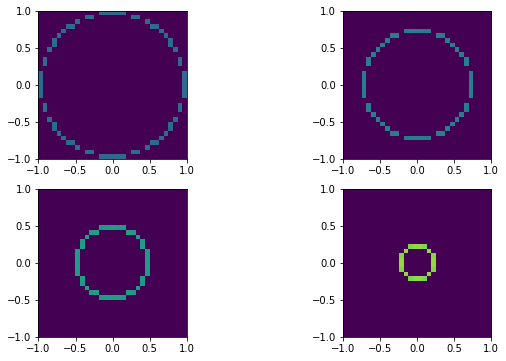

In [4]:
# Let's look at how these contributions add up.
Nx,Ny = 32,32  # If these are even then the origin is not included.
phi   = np.zeros( (Nx,Ny) )
x,y   = np.linspace(-1,1,Nx),np.linspace(-1,1,Ny)
xx,yy = np.meshgrid(x,y,indexing='ij')
#
fig,ax= plt.subplots(2,2,figsize=(10,6))
#
dt = 0.05
for i,tret in enumerate(np.arange(-1.0,0.0,5*dt)):
    iy,ix= i%2,i//2
    dphi = compute_dphi(tret,dt,xx,yy)
    img  = np.log(1+dphi.T)
    ax[ix,iy].imshow(img,origin='lower',extent=[-1,1,-1,1],\
                    vmin=0.0,vmax=2.)

In [5]:
# Start with no potential:
Nx,Ny = 32,32  # If even then origin is not included.
phi   = np.zeros( (Nx,Ny) )
x,y   = np.linspace(-1,1,Nx),np.linspace(-1,1,Ny)
xx,yy = np.meshgrid(x,y,indexing='ij')
# Now do the "integral" over retarded time,
# adding up the contribution at each time.
dt = 0.05
for tret in np.arange(-1.5,0.0,dt):
    phi += compute_dphi(tret,dt,xx,yy)

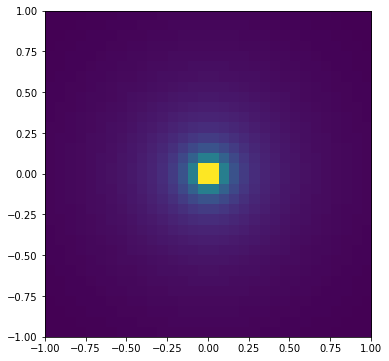

In [6]:
# Now make a plot of the potential for the stationary charge at
# the origin.
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.imshow(phi.T,origin='lower',extent=[-1,1,-1,1])

That seems sensible.  Let's make the charge move.  We'll have it come in relativistically along the $y$ axis, then slow down and stop at $\vec{r}=\vec{0}$ at $t=0$.

In [7]:
def source(tret):
    """Returns the source position and velocity at (retarded) time tret."""
    roft    = np.array([0.0,0.0])
    voft    = np.array([0.0,0.0])
    dt      = 1.0 + tret
    roft[1] =-0.3 + 0.6*dt -   0.3*dt**2
    voft[1] =       0.6    - 2*0.3*dt
    return( (roft,voft) )
    #

Text(0, 0.5, '$v_y(t)$')

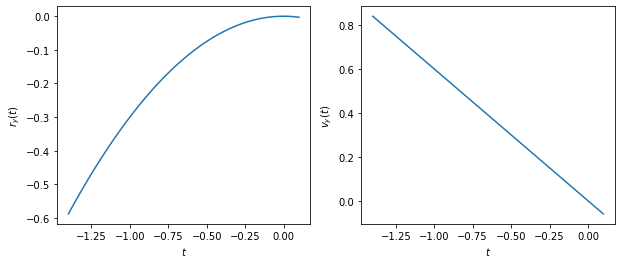

In [8]:
# Let's just plot r_y(t) and v_y(t) to check!
tt = np.linspace(-1.4,0.1,100)
ry = np.zeros_like(tt)
vy = np.zeros_like(tt)
for i in range(tt.size):
    roft,voft   = source(tt[i])
    ry[i],vy[i] = roft[1],voft[1]
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(tt,ry)
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$r_y(t)$')
ax[1].plot(tt,vy)
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$v_y(t)$')

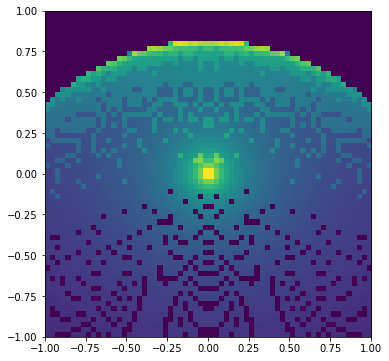

In [9]:
# What potential does that produce?
# Start with no potential:
Nx,Ny = 64,64  # If even then origin is not included.
phi   = np.zeros( (Nx,Ny) )
x,y   = np.linspace(-1,1,Nx),np.linspace(-1,1,Ny)
xx,yy = np.meshgrid(x,y,indexing='ij')
# Now do the "integral" over retarded time,
# adding up the contribution at each time.
dt = 0.01
for tret in np.arange(-1.5,0.0,dt):
    phi += compute_dphi(tret,dt,xx,yy)
# Now make a plot of the potential for the stationary charge at
# the origin.
fig,ax = plt.subplots(1,1,figsize=(10,6))
img = np.log(1+phi.T)
ax.imshow(img,origin='lower',extent=[-1,1,-1,1])

### Electric field ###

Ok, so now we can look at the electric field vector.  This is very similar to the potential, just with a few more terms.  We also need the acceleration now.  We begin with the stationary charge, which just tests the first term in our expansion.

In [10]:
def source(tret):
    """Returns the source position and velocity at (retarded) time tret."""
    roft    = np.array([0.0,0.0])
    voft    = np.array([0.0,0.0])
    aoft    = np.array([0.0,0.0])
    return( (roft,voft,aoft) )
    #

In [11]:
def compute_dE(tret,dt,xx,yy):
    """Computes the piece of E corresponding to retarded time tret, i.e. fills
    in the Ex and Ey arrays at those locations where -tret=R/c within tolerance dt."""
    roft,voft,aoft = source(tret)
    R   = np.sqrt( (xx-roft[0])**2 + (yy-roft[1])**2 )
    ww  = (R>-tret-dt/2)&(R<-tret+dt/2)
    dEx = np.zeros_like(xx)
    dEy = np.zeros_like(xx)
    if len(ww)>0:
        # Compute the full grid, then assign only part of it.
        # This isn't efficient, but it saves some typing.
        nhat_x  = (xx-roft[0]) / (R+1e-20)
        nhat_y  = (yy-roft[1]) / (R+1e-20)
        kappa   = 1 - (nhat_x*voft[0]+nhat_y*voft[1])
        gamma   = 1.0/np.sqrt(1.0-voft[0]**2-voft[1]**2)
        nmbx    = nhat_x - voft[0]
        nmby    = nhat_y - voft[1]
        crossz  = nmbx*aoft[1] - nmby*aoft[0]
        Ex      = nmbx/gamma**2/kappa**3/R**2
        Ex     += nmby*crossz/kappa**3/R
        Ey      = nmby/gamma**2/kappa**3/R**2
        Ey     +=-nmbx*crossz/kappa**3/R
        dEx[ww] = Ex[ww]
        dEy[ww] = Ey[ww]
    return((dEx,dEy))

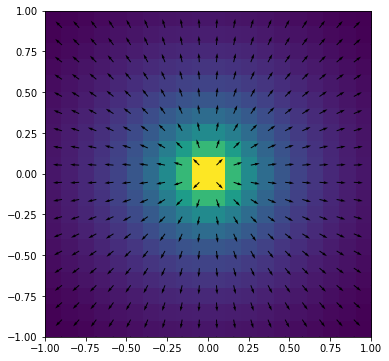

In [12]:
# What field does that produce?
Nx,Ny = 20,20  # If even then origin is not included.
Ex,Ey = np.zeros( (Nx,Ny) ),np.zeros( (Nx,Ny) )
x,y   = np.linspace(-1,1,Nx),np.linspace(-1,1,Ny)
xx,yy = np.meshgrid(x,y,indexing='ij')
# Now do the "integral" over retarded time,
# adding up the contribution at each time.
dt = 0.01
for tret in np.arange(-1.5,0.0,dt):
    dEx,dEy = compute_dE(tret,dt,xx,yy)
    Ex += dEx
    Ey += dEy
EE = np.sqrt(Ex**2+Ey**2)
# Now make a plot of the potential for the stationary charge at
# the origin.
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.imshow(np.log(1+EE.T),origin='lower',extent=[-1,1,-1,1])
ax.quiver(xx,yy,Ex/EE,Ey/EE)

In [13]:
def source(tret):
    """Returns the source position and velocity at (retarded) time tret."""
    roft    = np.array([0.0,0.0])
    voft    = np.array([0.0,0.0])
    aoft    = np.array([0.0,0.0])
    dt      = 1.0 + tret
    roft[1] =-0.3 + 0.6*dt -   0.3*dt**2
    voft[1] =       0.6    - 2*0.3*dt
    aoft[1] =              - 2*0.3
    return( (roft,voft,aoft) )
    #

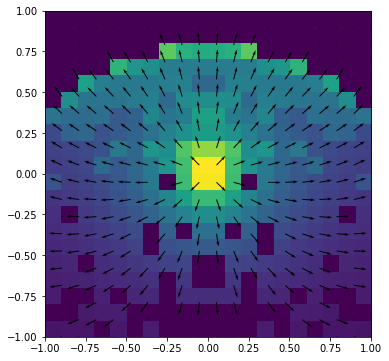

In [14]:
# What field does that produce?
Nx,Ny = 20,20  # If even then origin is not included.
Ex,Ey = np.zeros( (Nx,Ny) ),np.zeros( (Nx,Ny) )
x,y   = np.linspace(-1,1,Nx),np.linspace(-1,1,Ny)
xx,yy = np.meshgrid(x,y,indexing='ij')
# Now do the "integral" over retarded time,
# adding up the contribution at each time.
dt = 0.01
for tret in np.arange(-1.5,0.0,dt):
    dEx,dEy = compute_dE(tret,dt,xx,yy)
    Ex += dEx
    Ey += dEy
EE = np.sqrt(Ex**2+Ey**2) + 1e-20
# Now make a plot of the potential for the stationary charge at
# the origin.
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.imshow(np.log(1+EE.T),origin='lower',extent=[-1,1,-1,1])
ax.quiver(xx,yy,Ex/EE,Ey/EE)